# Classification. Linear models and KNN

In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [22]:
from sklearn.exceptions import NotFittedError

In [38]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        return 1/(1 + np.exp(-1 * weights @ X.T))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        ls = 0
        N, n_ = weights.shape
        for j in range(N):
            ls += (np.log(1+np.exp(-1*((weights @ x[j]) * y[j]))))
        #ls = ls/N+(np.linalg.norm(weights,axis=1)**2)/(2*self.C)
        
        ls = ls/N+(np.linalg.norm(weights, axis=1, ord = 2)**2)/(2*self.C)

        
        
        """
        N, n_ = weights.shape
        ls = np.zeros(N) 
        #print(N, n_)
        for k in range (N):
            for i in range (N):
                s = 0
                for j in range (n_):
                     s += weights[i,j]*x[i,j]
            #s = s + weights[i,0]        
            ls[k] = np.log(1+np.exp((-1)*s*y[i]))/N+np.linalg.norm(weights[k])/(2*self.C)
       # for j in range(N):
        #sum=np.log(1+np.exp(-1*((weights @x.T)   )))
        #print("2sl:", np.linalg.norm(weights)/(2*self.C))
        #print(ls)
        """
        
        return ls

    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        N = X_ext.shape[0]
        self.loss_hist=[]
        self.weights_hist=[]
        
        for i in range(self.max_iter):
            sum = 0
            self.weights_hist.append(self.weights_.copy())
            for j in range(N):
                t = (1-(1/(1+np.exp(-1*((self.weights_ @ X_ext[j]) * y[j])))))
                sum+=y[j] * X_ext[j] * t
            delta = (1 / N) * sum - self.weights_/self.C
            self.weights_ += self.eta * delta
            if np.sqrt(np.sum(((self.weights_hist[-1] - self.weights_)**2))) < self.tol:
                break
            
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return (self.predict_proba(X) >= 0.5)*2 - 1


In [39]:
from sklearn import datasets
from sklearn import metrics

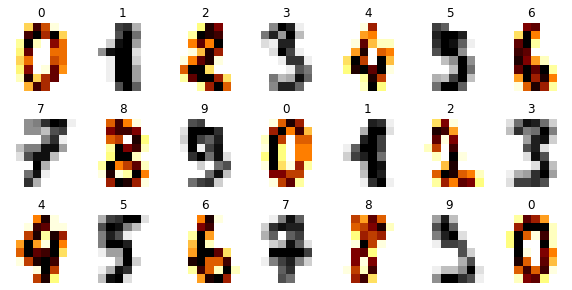

In [40]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [41]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [42]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [43]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [44]:
lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1]))

array([0.58661758, 0.40131234])

In [45]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [46]:
lr_clf.fit(X_train, y_train)

In [47]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [48]:
model = CustomLogisticRegression()

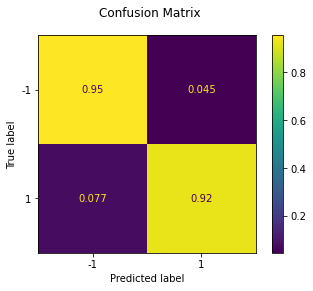

In [49]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [50]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [51]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

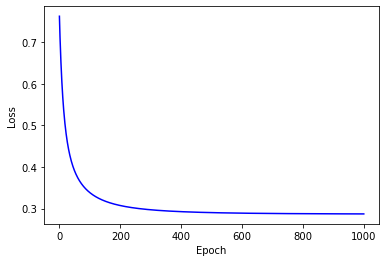

In [52]:
X_train_ext = np.hstack([np.ones((X_train.shape[0], 1)), X_train]) 

x_count = np.array(range(len(model.weights_hist)))
y_loss = model.get_loss(X_train_ext, np.array(model.weights_hist),y_train)
plt.plot(x_count, y_loss, 'b-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();


**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

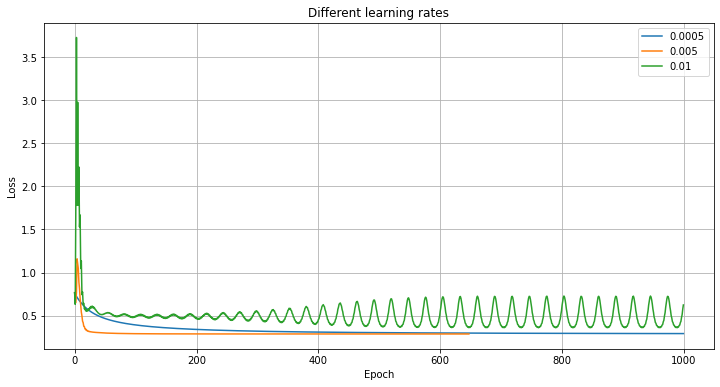

In [53]:
plt.figure(figsize=(12, 6))
eta_list = [0.0005,0.005,0.01]
for e in eta_list:
    model_eta_list = CustomLogisticRegression(eta=e)
    model_eta_list.fit(X_train, y_train)
    x_count_eta= np.array(range(len(model_eta_list.weights_hist)))
    y_loss_eta = model_eta_list.get_loss(X_train_ext, np.array(model_eta_list.weights_hist),y_train)
    plt.plot(x_count_eta, y_loss_eta)

plt.title('Different learning rates')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(eta_list)

plt.show();

##### LR = 0.0005 - немного уменьшило скорость сходимости функции потерь
##### LR = 0.005 - достигли заданной точности быстрее, однако вначале был скачок к увеличению потерь
##### LR = 0.01 - также скачок и "резонанс"-не нахождение оптимальных весов, перескок через минимум



**(0.5 points)** Try different regularization parameter values and compare the model quality.

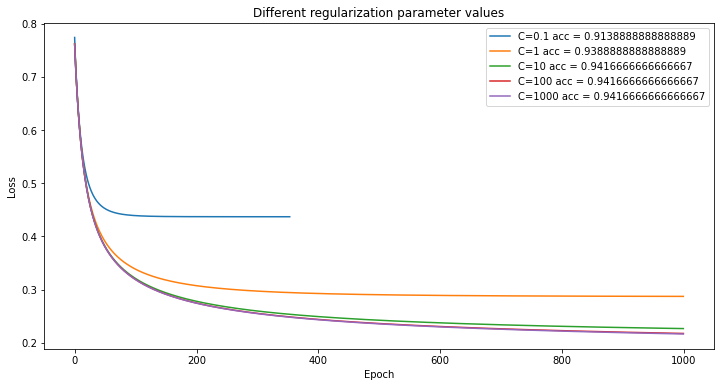

In [62]:
plt.figure(figsize=(12, 6))
plt.title('Different regularization parameter values')
plt.xlabel('Epoch')
plt.ylabel('Loss')
C_list = [0.1, 1, 10,100,1000]
list_leg = []
for c in C_list:
    model_C_list = CustomLogisticRegression(C=c)
    model_C_list.fit(X_train, y_train)
    x_count1= np.array(range(len(model_C_list.weights_hist)))
    y_loss1 = model_C_list.get_loss(X_train_ext, np.array(model_C_list.weights_hist),y_train)
    plt.plot(x_count1, y_loss1)
    test_acc = metrics.accuracy_score(y_pred=model_C_list.predict(X_test), y_true=y_test)
    list_leg.append("C="+str(c)+" acc = "+str(test_acc))
plt.legend(list_leg)



##### При увеличении параметра регуляризации до 10 мы улучшили модель, однако далее улучшение не происходит, про С=0,1 точность упала.

**(0.5 points)** Compare zero initialization and random initialization. 

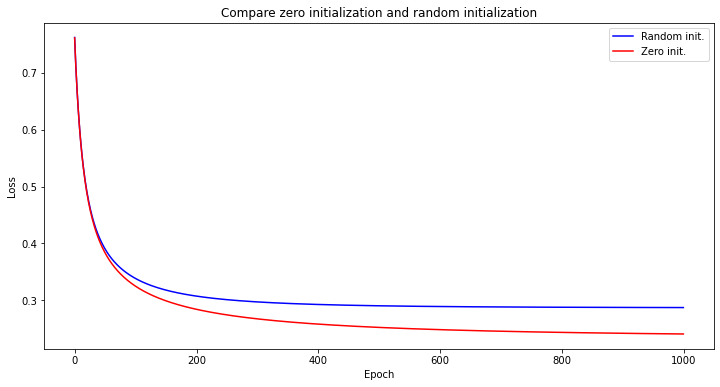

In [63]:
model_zero = CustomLogisticRegression(C=True)
model_zero.fit(X_train, y_train)

plt.figure(figsize=(12, 6))
plt.plot(x_count, y_loss, 'b-')
x_count_z= np.array(range(len(model_C_list.weights_hist)))
y_loss_z = model_C_list.get_loss(X_train_ext, np.array(model_zero.weights_hist),y_train)
plt.plot(x_count_z, y_loss_z,'r-')
plt.title('Compare zero initialization and random initialization')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Random init.','Zero init.'])


##### Нулевые веса инициализации незначительно уменьшили функцию потерь

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [81]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9, metod_dist="evql"):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        self.metod_dist = metod_dist
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        p=np.empty((X.shape[0],Y.shape[0]))
        p1=np.empty((X.shape[0],Y.shape[0]))
        if self.metod_dist == "manhatten":
            for i in range (X.shape[0]):
                for j in range (Y.shape[0]):
                    p[i,j] =np.linalg.norm(X[i]-Y[j], ord=1)
            return p
        else:
            for i in range (X.shape[0]):
                for j in range (Y.shape[0]):
                     p[i,j] = np.linalg.norm(X[i]-Y[j])
            return p
    
    
    def get_class_weights(self, y, weights):
        from collections import Counter

        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        w_ = np.zeros(len(self.classes_))
    
        for i,ik in enumerate (self.classes_):
            if ik in y:
                for j,jk in enumerate (y):
                    if (jk==ik):
                        w_[i] += weights[j]
        return w_ 

        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """

        if hasattr(self, 'points'):

            dist_ = self.get_pairwise_distances(X, self.points)

            rez = np.zeros((X.shape[0], len(self.classes_)))
            weights_of_points = np.ones(dist_.shape)

            s = np.sort(dist_, axis=1)
            s_indx = np.argsort(dist_, axis=1)

            if self.weights == 'distance':
                weights_of_points = 1/(s[:,:self.n_neighbors]+self.eps) 
           # print("Нач.веса(uniform/distanse)")
           # print(weights_of_points)
            for i in range(X.shape[0]):
                rez[i] = self.get_class_weights(self.y[s_indx[i,:self.n_neighbors]], weights_of_points[i])  
                rez[i] = rez[i]/np.sum(weights_of_points[i])
            return rez
            
            if self.weights not in ['distance','uniform']: 
                raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        a = np.zeros(X.shape[0])
        a = np.argmax(self.predict_proba(X),axis = 1)
        return a
        pass

In [65]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [66]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [67]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

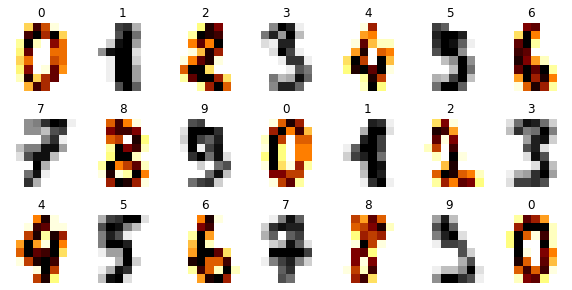

In [68]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [69]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [70]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

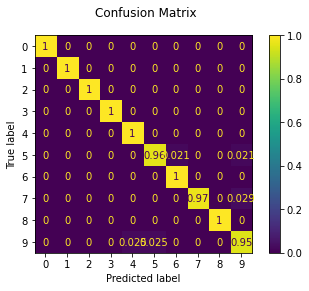

In [71]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [72]:
train_acc, test_acc

(1.0, 0.9861111111111112)

In [73]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

##### Были ошибки в определении 5 - (6, 9), 7 - 9, 9 - (4, 5), что вполне объяснимо с похожестью их изображений в низком разрешении

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

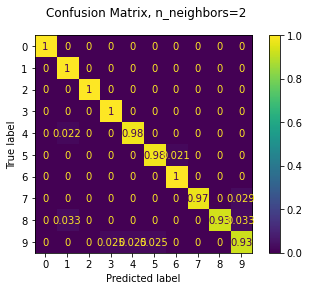

test_acc= 0.9777777777777777


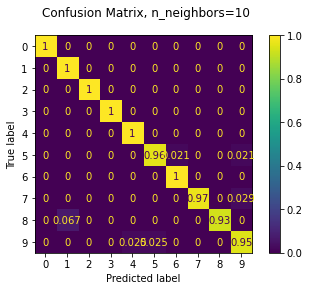

test_acc= 0.9805555555555555


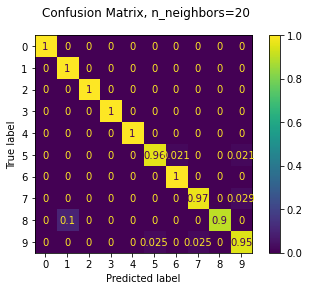

test_acc= 0.9777777777777777


In [74]:
n_neighbors_list = [2, 10, 20]

for n_neighbors_ in n_neighbors_list:
    model_n_neighbors = CustomKNeighborsClassifier(n_neighbors=n_neighbors_, weights='distance')
    model_n_neighbors.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(model_n_neighbors, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix, n_neighbors="+str(n_neighbors_))
    plt.show()
    print("test_acc=",metrics.accuracy_score(y_pred=model_n_neighbors.predict(X_test), y_true=y_test))
    

##### Изменение параметра n_neighbors, в обе стороны приводит к ухудшению качества модели

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

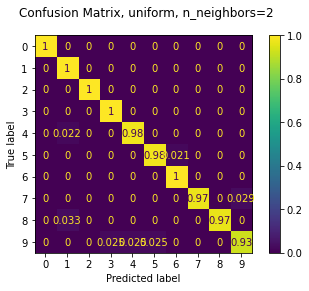

test_acc= 0.9805555555555555


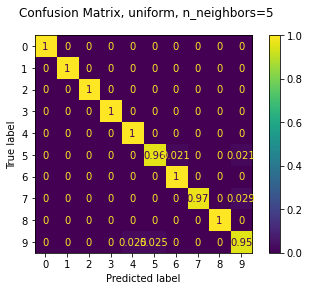

test_acc= 0.9861111111111112


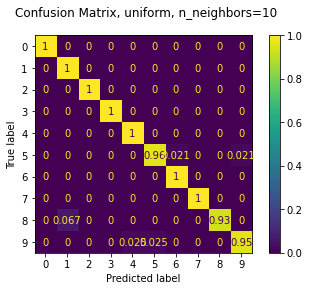

test_acc= 0.9833333333333333


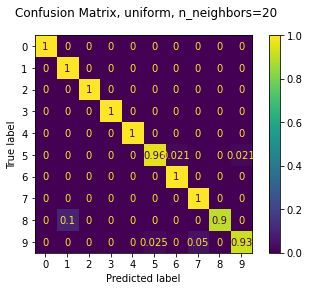

test_acc= 0.9777777777777777


In [75]:
n_neighbors_list = [2, 5, 10, 20]
for n_neighbors_ in n_neighbors_list:
    model_uniform = CustomKNeighborsClassifier(n_neighbors=n_neighbors_, weights='uniform')
    model_uniform.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(model_uniform, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix, uniform, n_neighbors="+str(n_neighbors_))
    plt.show()
    print("test_acc=",metrics.accuracy_score(y_pred=model_uniform.predict(X_test), y_true=y_test))

##### точность модели при n_neighbors=5 осталась такая же, но при изменении числа соседей в обе стороны она падает.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

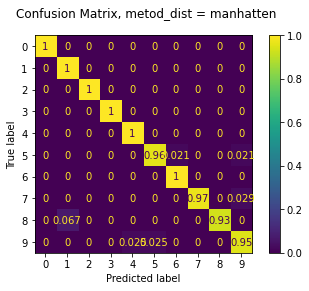

test_acc= 0.9805555555555555


In [83]:
model_manhatten = CustomKNeighborsClassifier(n_neighbors=5, weights='distance', metod_dist = "manhatten")
model_manhatten.fit(X_train, y_train)
disp = metrics.plot_confusion_matrix(model_manhatten, X_test, y_test, normalize='true')
disp.figure_.suptitle("Confusion Matrix, metod_dist = manhatten")
plt.show()
print("test_acc=",metrics.accuracy_score(y_pred=model_manhatten.predict(X_test), y_true=y_test))

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

Манхэтонское измерение расстояние применяется при не возможности применить кратчайшее расстояние и приходится приближатся по ордам-"кварталам", например в в городах по улицам и авеню

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [6]:
PATH = "./data/"

In [7]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [8]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** 



In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       96708 non-null   float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      99866 non-null   float64
 9   Cabin     32134 non-null   object 
 10  Embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 9.2+ MB


In [10]:
data.shape

(100000, 11)

In [11]:
data.describe(include=["number"])

,Survived,Pclass,Age,SibSp,Parch,Fare
count,100000.000000,100000.000000,96708.000000,100000.000000,100000.000000,99866.00000
mean,0.427740,2.106910,38.355472,0.397690,0.454560,43.92933
std,0.494753,0.837727,18.313556,0.862566,0.950076,69.58882
min,0.000000,1.000000,0.080000,0.000000,0.000000,0.68000
25%,0.000000,1.000000,25.000000,0.000000,0.000000,10.04000
50%,0.000000,2.000000,39.000000,0.000000,0.000000,24.46000
75%,1.000000,3.000000,53.000000,1.000000,1.000000,33.50000
max,1.000000,3.000000,87.000000,8.000000,9.000000,744.66000


In [12]:
data.describe(include = "object")

,Name,Sex,Ticket,Cabin,Embarked
count,100000,100000,95377,32134,99750
unique,92144,2,75331,26992,3
top,"Johnson, John",male,A/5,C19828,S
freq,31,56114,602,6,72139


**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

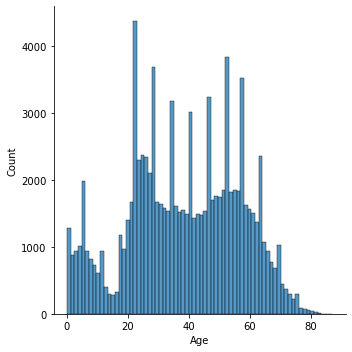

In [14]:
sns.displot(data, x="Age")
plt.show()

In [15]:
data.groupby('Survived')['Age'].describe()


,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,55290.0,36.708695,17.809058,0.08,24.0,36.0,52.0,83.0
1,41418.0,40.553799,18.742172,0.08,27.0,43.0,55.0,87.0


#### survived passengers: mean=36.654986, median(50%)=36
#### deceased passengers: mean=40.546875, median(50%)=43

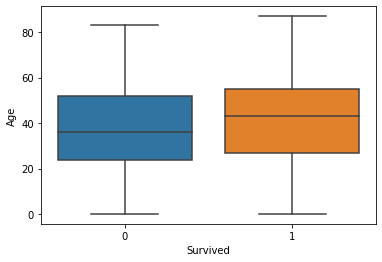

In [17]:
ax = sns.boxplot(x='Survived', y='Age', data=data) 
plt.show()

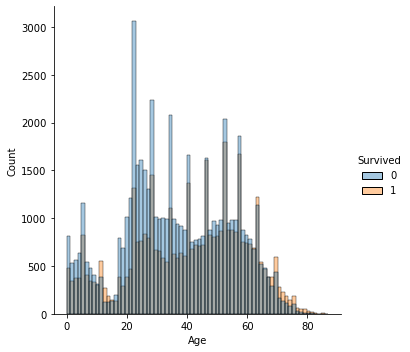

In [19]:
sns.displot(data, x="Age",hue="Survived",alpha=0.4)

< your thoughts >

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

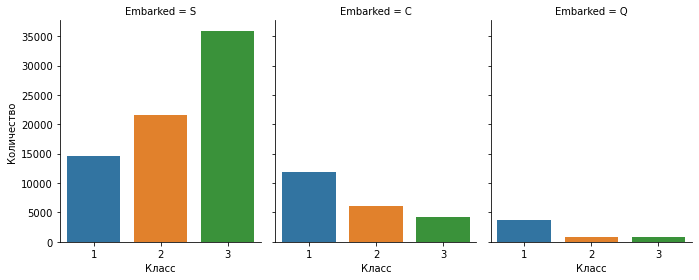

In [21]:
sns.catplot(x="Pclass", col="Embarked", col_wrap=4,
                data=data, kind="count", height=4, aspect=.8).set(xlabel='Класс', ylabel='Количество')#
plt.show()

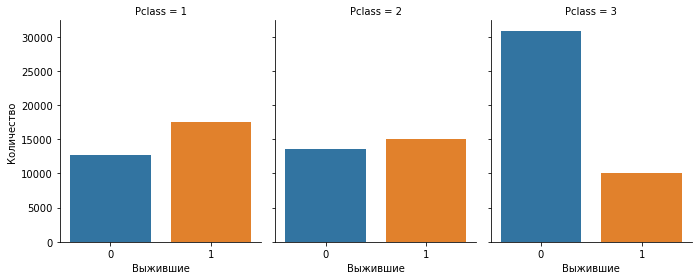

In [22]:
sns.catplot(x="Survived", col="Pclass", col_wrap=4,
                data=data, kind="count", height=4, aspect=.8).set(xlabel='Выжившие', ylabel='Количество')#
plt.show()

####  В первом классе наблюдаем макимальное количество выживших. Большое влияние на выживаемость оказали: пол, порт посадки, класс.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [23]:
percent = data.isnull().sum()*100/data.shape[0]
percent.to_frame().set_axis(['%Nan'], axis=1).sort_values(by='%Nan', ascending=False)

,%Nan
Cabin,67.866
Ticket,4.623
Age,3.292
Embarked,0.250
Fare,0.134
Survived,0.000
Pclass,0.000
Name,0.000
Sex,0.000
SibSp,0.000


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?



##### Удалим столбцы 'Cabin', 'Ticket' ,'PassengerId' как имеющие много пропусков. И 'Name', как не имеющее корреляции с целью.
#####  Пропущенные данные "порт отправления" заполним модою. "Age"  медианой сгруппированных данных по "Классу, "Полу", "Порту отправления", и семейными положением. "Fare" заполним средним по группе "Класс" и "Порт отправления". 

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [24]:
train_data = data.reset_index()
train_data = train_data.drop(["PassengerId","Cabin", "Name","Ticket"], axis=1)

#print(train_data.groupby(['Pclass','Sex','Embarked','SibSp','Parch'])['Age'].median())
#train_data['Age'] = train_data['Age'].fillna(train_data.groupby(['Pclass','Sex','Embarked','SibSp','Parch'])['Age'].transform('mean'))

train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].mode()[0])
train_data['Age'] = train_data['Age'].fillna(train_data.groupby(['Pclass','Sex','Embarked','SibSp','Parch'])['Age'].transform('median'))
train_data['Age'] = train_data['Age'].fillna(train_data['Age'].median())
train_data['Fare'] = train_data['Fare'].fillna(train_data.groupby(['Pclass','Embarked'])['Fare'].transform('mean'))

train_data.isna()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
99995,False,False,False,False,False,False,False,False
99996,False,False,False,False,False,False,False,False
99997,False,False,False,False,False,False,False,False
99998,False,False,False,False,False,False,False,False


In [25]:
train_data.describe(include = "object")

,Sex,Embarked
count,100000,100000
unique,2,3
top,male,S
freq,56114,72389


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [26]:
from sklearn.preprocessing import LabelEncoder
l_coder = LabelEncoder()
train_data['Sex'] = l_coder.fit_transform(train_data['Sex'])
train_data['Embarked'] = l_coder.fit_transform(train_data['Embarked'])
train_data


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,1,1,41.00,2,0,27.14,2
1,0,3,1,33.00,0,0,13.35,2
2,0,3,1,0.33,1,2,71.29,2
3,0,3,1,19.00,0,0,13.04,2
4,1,3,1,25.00,0,0,7.76,2
...,...,...,...,...,...,...,...,...
99995,1,2,0,62.00,0,0,14.86,0
99996,0,2,1,66.00,0,0,11.15,2
99997,0,3,1,37.00,0,0,9.95,2
99998,0,3,1,51.00,0,1,30.92,2


In [27]:

X_data = train_data.iloc[:,1:].values
y_data = train_data.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X_data,y_data,test_size=0.3,random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
k = range(1,20)
acc = []
for i in k:
    model_knn = KNeighborsClassifier(n_neighbors=i)
    model_knn.fit(X_train, y_train)
    y_pred = model_knn.predict(X_test) 
    acc.append(metrics.accuracy_score(y_test,y_pred))

plt.figure(figsize=(12, 6))
plt.plot(k, acc, 'b-')
k=np.argmax(acc)

(70000, 7) (30000, 7) (70000,) (30000,)


NameError: name 'metrics' is not defined

In [53]:
model_knn = KNeighborsClassifier(n_neighbors=14)
model_knn.fit(X_data, y_data)
data_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')
data_test = data_test.reset_index()
data_pass = data_test['PassengerId']
data_test = data_test.drop(["PassengerId","Cabin", "Name","Ticket"], axis=1)
data_test['Embarked'] = data_test['Embarked'].fillna(data_test['Embarked'].mode()[0])
data_test['Age'] = data_test['Age'].fillna(data_test.groupby(['Pclass','Sex','Embarked','SibSp','Parch'])['Age'].transform('median'))
data_test['Age'] = data_test['Age'].fillna(data_test['Age'].median())
data_test['Fare'] = data_test['Fare'].fillna(data_test.groupby(['Pclass','Embarked'])['Fare'].transform('mean'))
#train_data.isna()
data_test['Sex'] = l_coder.fit_transform(data_test['Sex'])
data_test['Embarked'] = l_coder.fit_transform(data_test['Embarked'])
y_pred = model_knn.predict(data_test)
#print(metrics.accuracy_score(y_test,y_pred))


In [54]:
print(type(y_pred))

<class 'numpy.ndarray'>


In [55]:
resultFile = open(("y_pred_test.csv"),"wb")
f = pd.DataFrame(y_pred,columns=['Survived'], index = data_pass).reset_index()
f.to_csv("y_pred_test.csv",index=False) 

y_pred_test.csv
Submitted by Alexandr H. · Submitted a few seconds ago

#### Score: 0.72932


Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.